In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import shuffle
import sklearn.metrics
import scipy

In [2]:
# data source
red = pd.read_csv('LOESS Plot Data.csv')
red.head()

,record_id,mat_del_igg,inf_igg,severity,latency
0,21,9.380000,14.130000,3.0,81.0
1,57,39.830002,37.880001,3.0,125.0
2,83,1.260000,1.650000,2.0,19.0
3,101,11.210000,NaN,2.0,86.0
4,106,0.130000,0.140000,2.0,0.0


In [3]:
mat = red[pd.isna(red['severity'])]
mat = mat.dropna(subset = ['mat_del_igg']).copy()
iggs = np.array(mat['mat_del_igg'])

149.14570474154
{'amplitude': 1.8838832774301453, 'igg_hl': 40.0, 'long_hl': 2349.1923121655277, 'name': 'vax', 'short_hl': 18.0, 'short_prop': 1.0}


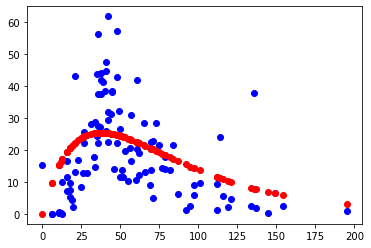

In [4]:
# Lancet model
# citation: 
# White M, Idoko O, Sow S, Diallo A, Kampmann B, Borrow R, Trotter C. 
# Antibody kinetics following vaccination with MenAfriVac: 
#  an analysis of serological data from randomised trials. 
# Lancet Infect Dis. 2019 Mar;19(3):327-336. doi: 10.1016/S1473-3099(18)30674-1. 
# PMID: 30745277.

def ab_level_params(params, data):
        X, y = data
        rs = np.log(2)/params[2]
        rl = np.log(2)/params[3]
        ra = np.log(2)/params[1]
        if ra != rs:
            short = params[0] * (np.exp(-1*rs*X)-np.exp(-1*ra*X))/(ra-rs)
        else: short = 0
        if ra != rl:
            long = (1-params[0]) * (np.exp(-1*rl*X)-np.exp(-1*ra*X))/(ra-rl)
        else: long = 0
        val = params[4] * (short + long)
        err = val - y
        return np.sum(err * err)


class AB_Estimator(BaseEstimator, ClassifierMixin):

    def __init__(self, name, short_prop = 0.95, igg_hl=15.0, short_hl = 5.0, long_hl=1000.0, amplitude = 10.0):
        self.short_prop = short_prop
        self.igg_hl = igg_hl
        self.short_hl = short_hl
        self.long_hl = long_hl
        self.name = name
        self.amplitude = amplitude

    def _rate(self, d):
        return np.log(2)/d

    def _ab_level(self, X):
        rs = self._rate(self.short_hl)
        rl = self._rate(self.long_hl)
        ra = self._rate(self.igg_hl)
        if ra != rs:
            short = self.short_prop * (np.exp(-1*rs*X)-np.exp(-1*ra*X))/(ra-rs)
        else: short = 0
        if ra != rl:
            long = (1-self.short_prop) * (np.exp(-1*rl*X)-np.exp(-1*ra*X))/(ra-rl)
        else: long = 0
        val = self.amplitude * (short + long)
        return val   
    
    
    def _optimize_scipy(self, param_bounds, n_iter = 25):
                
        params = [self.short_prop, self.igg_hl, self.short_hl, self.long_hl, self.amplitude]
        bounds = [param_bounds[key] for key in param_bounds]
        X = self.X_   
        y = self.y_
        data = (X,y,)
        res = scipy.optimize.differential_evolution(ab_level_params, 
                                                    bounds = bounds, args = ((X,y,),), maxiter = n_iter)
        self.set_params(**{'short_prop':res.x[0], 'igg_hl':res.x[1], 'short_hl':res.x[2], 
                               'long_hl':res.x[3], 'amplitude':res.x[4]})
    
    def _optimize_ab(self, param_bounds, zone = 10):
        X = self.X_
        y = self.y_
        param_names = shuffle(['short_prop', 'igg_hl', 'short_hl', 'long_hl', 'amplitude'])
        ranges = []
        for param in param_names:
            low_bound, high_bound = param_bounds[param]
            current = self.get_params()[param]
            low = max(low_bound, current * (1-zone/100.))
            hi = min(high_bound, current * (1 + zone/100.))
            param_range = np.arange(low, hi, current/100.0)            
            ranges.append(param_range)

        for search_range, param_name in zip(ranges, param_names):
            errs = []
            start = min(search_range)
            for guess in search_range:
                self.set_params(**{param_name:guess})
                y_pred = self._ab_level(X)
                err = y - y_pred
                errs.append(np.mean(err*err))
            best = search_range[np.argmin(errs)]
            self.set_params(**{param_name:best})
        return
    
    def fit(self, X, y, 
            param_bounds = {'short_prop':(0.01, 1.0), 
                            'igg_hl':(10.0,40.0), 
                            'short_hl':(0.1, 18.0),
                            'long_hl':(40.1,5000.0),
                            'amplitude':(0.01,10000.0)}, 
            n_iter=25):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d = False, y_numeric = True)        
        self.X_ = X
        self.y_ = y
        #for a in range(n_iter): self._optimize_ab(param_bounds)
        self._optimize_scipy(param_bounds, n_iter)
        # Return the classifier
        return self
    
    def predict(self, X):        
        check_is_fitted(self) # Check is fit had been called
        y_pred = self._ab_level(X)
        
        return y_pred
    
    def score(self, X=[], y=[]):
        check_is_fitted(self)
        if len(X) == 0: X = self.X_
        if len(y) == 0: y = self.y_
        y_pred = self._ab_level(X)
        err = y - y_pred
        
        return np.mean(err * err)

    
ab_pred = AB_Estimator('vax')
ab_pred.fit(mat['latency'], iggs, n_iter = 1000)
print(ab_pred.score())
print(ab_pred.get_params())

igg_pred = ab_pred.predict(mat['latency'])
plt.close()
plt.scatter(mat['latency'], iggs, c = 'b')
plt.scatter(mat['latency'], igg_pred, c = 'r')
plt.show()

In [5]:
from sklearn.model_selection import RepeatedKFold
X = np.array(mat['latency'])
y = np.array(mat['mat_del_igg'])
rkf = RepeatedKFold(n_splits=5, n_repeats=20)
param_df = pd.DataFrame()
test_errs = []
for train_index, test_index in rkf.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    ab_pred = AB_Estimator('vax')
    ab_pred = ab_pred.fit(train_X, train_y, n_iter = 100)
    score = ab_pred.score(test_X, test_y)
    param_df = param_df.append(ab_pred.get_params(), ignore_index = True)
    test_errs.append(score)

param_df['error'] = test_errs
param_df.to_csv('kfold_params.csv', index = False)
param_df.head()

,amplitude,igg_hl,long_hl,name,short_hl,short_prop,error
0,1.656046,22.240857,40.100000,vax,18.0,0.01,129.036804
1,1.856703,40.000000,55.695188,vax,18.0,1.00,188.607628
2,1.895852,36.373664,2574.138479,vax,18.0,1.00,208.192428
3,1.872576,40.000000,629.450270,vax,18.0,1.00,130.178331
4,2.049931,37.298418,2195.449102,vax,18.0,1.00,117.459869


In [6]:
param_df.describe(percentiles = [0.025,0.975])

,amplitude,igg_hl,long_hl,short_hl,short_prop,error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.884460,37.273965,1933.331974,17.820387,0.902244,154.629933
std,0.100052,5.429577,1448.572263,1.789949,0.293544,48.906855
min,1.578529,19.967840,40.100000,0.100000,0.010000,69.030214
2.5%,1.646213,20.792302,40.100000,18.000000,0.010000,82.099824
50%,1.902139,39.555113,2050.456866,18.000000,1.000000,138.497129
97.5%,2.058345,40.000000,4736.141641,18.000000,1.000000,269.344540
max,2.082226,40.000000,4920.379154,18.000000,1.000000,321.525812


In [8]:
red = pd.read_csv('LOESS Plot Data.csv')
red['severity'] = red['severity'].fillna('vax')
severities = pd.get_dummies(red['severity'], prefix = 'severity')
red = pd.concat([red, severities], axis = 1)
red['severity_mod_sev'] = red['severity_2.0'] + red['severity_3.0']
red['symp_covid'] = red['severity_1.0'] + red['severity_2.0'] + red['severity_3.0']
analytes = []
severities = []

param_findings = pd.DataFrame()


for severity in ['severity_1.0', 'severity_2.0', 'severity_3.0', 'severity_vax', 'symp_covid']:        
    dataset = red[red[severity]==1]
    dataset = dataset.dropna(subset = ['mat_del_igg']).copy()
    X = np.array(dataset['latency'])
    y = np.array(dataset['mat_del_igg'])
    rkf = RepeatedKFold(n_splits=5, n_repeats=20)
    param_df = pd.DataFrame()
    test_errs = []
    for train_index, test_index in rkf.split(X):
        train_X, test_X = X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        ab_pred = AB_Estimator(severity)
        ab_pred = ab_pred.fit(train_X, train_y, n_iter = 100)
        score = ab_pred.score(test_X, test_y)
        param_df = param_df.append(ab_pred.get_params(), ignore_index = True)
        test_errs.append(score)

    param_df['error'] = test_errs
    param_df.to_csv(f'kfold_params_mat_del_igg_{severity}.csv', index = False)
    severities.append(severity)
    row = pd.Series()
    for param in ['igg_hl', 'short_hl', 'long_hl', 'short_prop', 'amplitude']:
        vals = param_df.describe(percentiles = [0.025,0.975])[param]
        vals.index = param + '_' + vals.index
        row = pd.concat([row, vals])
    param_findings = pd.concat([param_findings, row], axis = 1)

param_findings = param_findings.transpose()
param_findings['severity'] = severities
param_findings.head()
param_findings.to_csv('ab_parameters_mat_del_igg.csv', index = False)

/tmp/ipykernel_36627/949085046.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_36627/949085046.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_36627/949085046.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_36627/949085046.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_36627/949085046.py:33: DeprecationWarning: The default dtype for empty Series will be 'ob

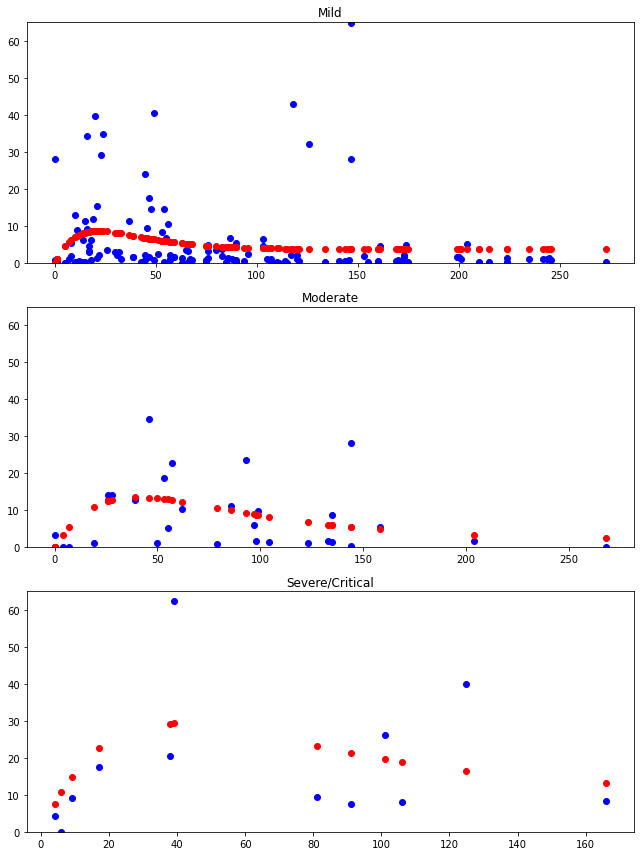

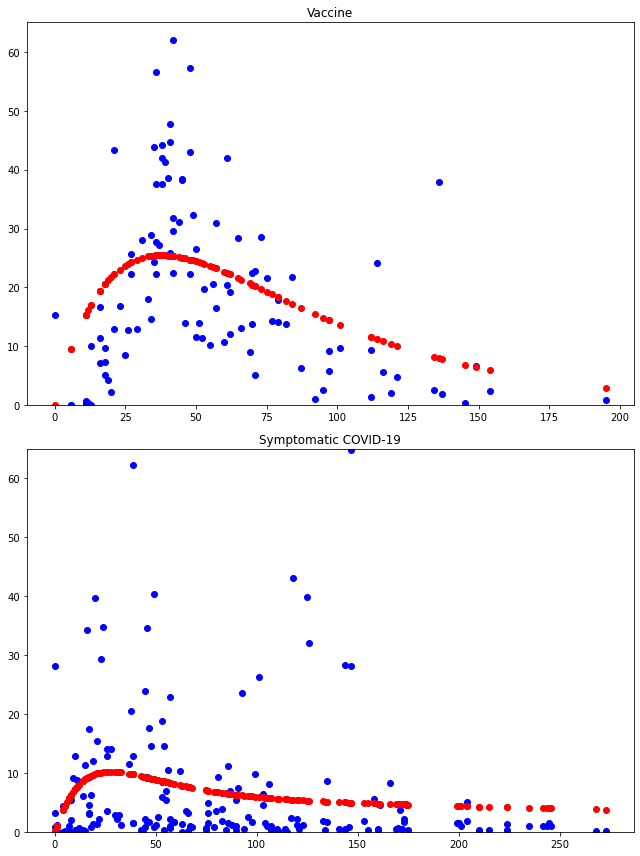

In [13]:
severity_names = {'severity_0.0':'Asymptomatic', 'severity_1.0':'Mild', 
                  'severity_mod_sev':'Moderate to Severe', 'severity_vax':'Vaccine',
                 'any_covid':'Any SARS-CoV-2', 'symp_covid':'Symptomatic COVID-19',
                 'severity_2.0':'Moderate', 'severity_3.0':'Severe/Critical'}


plt.close()
fig = plt.figure(figsize = (9, 12))
for severity, frame in zip(['severity_1.0', 'severity_2.0', 'severity_3.0'], range(1,4)):        
    dataset = red[red[severity] == 1]
    dataset = dataset.dropna(subset = ['mat_del_igg']).copy()
    X = np.array(dataset['latency'])
    y = np.array(dataset['mat_del_igg'])
    ab_pred = AB_Estimator(severity)
    ab_pred = ab_pred.fit(X, y)
    score = ab_pred.score(X, y)
    ax = fig.add_subplot(3,1, frame)
    ax.scatter(X, y, c ='b')
    ax.scatter(X, ab_pred.predict(X), c = 'r')
    ax.set_title(severity_names[severity])
    ax.set_ylim(0,65)
plt.tight_layout()
plt.savefig(f'mat_del_igg_severity_latency.png', dpi = 600)
plt.show()

plt.close()
fig = plt.figure(figsize = (9, 12))
for severity, frame in zip(['severity_vax', 'symp_covid'], range(1,3)):        
    dataset = red[red[severity] == 1]
    dataset = dataset.dropna(subset = ['mat_del_igg']).copy()
    X = np.array(dataset['latency'])
    y = np.array(dataset['mat_del_igg'])
    ab_pred = AB_Estimator(severity)
    ab_pred = ab_pred.fit(X, y)
    score = ab_pred.score(X, y)
    ax = fig.add_subplot(2,1, frame)
    ax.scatter(X, y, c ='b')
    ax.scatter(X, ab_pred.predict(X), c = 'r')
    ax.set_title(severity_names[severity])
    ax.set_ylim(0,65)
plt.tight_layout()
plt.savefig(f'mat_del_igg_vax_symp_covid_latency.png', dpi = 600)
plt.show()

In [14]:


c_names = ['mild, mod', 'mild, sev', 'mod, sev']

#for analyte in ['mat_del_igg', 'inf_igg']:
mild_m = pd.read_csv('kfold_params_mat_del_igg_severity_1.0.csv')
mod_m = pd.read_csv('kfold_params_mat_del_igg_severity_2.0.csv')
sev_m = pd.read_csv('kfold_params_mat_del_igg_severity_3.0.csv')
vax_m = pd.read_csv('kfold_params_mat_del_igg_severity_vax.csv')
symp_m = pd.read_csv('kfold_params_mat_del_igg_symp_covid.csv')
comparisons = [(mild_m, mod_m), (mild_m, sev_m), (mod_m, sev_m)]

for param in ['amplitude', 'igg_hl', 'long_hl', 'short_hl', 'short_prop']:
    stat, p = scipy.stats.kruskal(mild_m[param], mod_m[param], sev_m[param])
    print(f'Testing mat_del_igg, {param}, p-value: {p}')
    if p < 0.05:
        for (x, y), name in zip(comparisons, c_names):
            U1, p_sub = scipy.stats.mannwhitneyu(x[param], y[param])
            if p_sub < 0.05:
                print(f'\t subgroup: {name}, p:{p_sub}')
    U1, p_sub = scipy.stats.mannwhitneyu(vax_m[param], symp_m[param])
    print(f'Testing mat_del_igg symp vs. vax {param}, p-value: {p}')
            
# infant  
'''
mild_i = pd.read_csv('kfold_params_inf_igg_severity_1.0.csv')
mod_i = pd.read_csv('kfold_params_inf_igg_severity_2.0.csv')
sev_i = pd.read_csv('kfold_params_inf_igg_severity_3.0.csv')
vax_i = pd.read_csv('kfold_params_inf_igg_severity_vax.csv')
comparisons_i = [(mild_i, mod_i), (mild_i, sev_i), (mild_i, vax_i), (mod_i, sev_i), (mod_i, vax_i), (sev_i, vax_i)]
for param in ['amplitude', 'igg_hl', 'long_hl', 'short_hl', 'short_prop']:
    stat, p = scipy.stats.kruskal(mild_i[param], mod_i[param], sev_i[param], vax_i[param])
    print(f'Testing inf_igg, {param}, p-value: {p}')
    if p < 0.05:
        for (x, y), name in zip(comparisons_i, c_names):
            U1, p_sub = scipy.stats.mannwhitneyu(x[param], y[param])
            if p_sub < 0.05:
                print(f'\t subgroup: {name}, p:{p_sub}')
'''

Testing mat_del_igg, amplitude, p-value: 9.628993753623034e-46
	 subgroup: mild, mod, p:1.0745956028773706e-16
	 subgroup: mild, sev, p:6.165770376943317e-28
	 subgroup: mod, sev, p:6.054907743266779e-33
Testing mat_del_igg symp vs. vax amplitude, p-value: 9.628993753623034e-46
Testing mat_del_igg, igg_hl, p-value: 9.859641024925878e-41
	 subgroup: mild, mod, p:4.635477166052256e-33
	 subgroup: mild, sev, p:6.101179867472563e-28
	 subgroup: mod, sev, p:1.2369020515517433e-05
Testing mat_del_igg symp vs. vax igg_hl, p-value: 9.859641024925878e-41
Testing mat_del_igg, long_hl, p-value: 1.428525514501098e-08
	 subgroup: mild, mod, p:9.663383730822675e-06
	 subgroup: mild, sev, p:0.0032570191161932554
	 subgroup: mod, sev, p:3.1657034060022615e-08
Testing mat_del_igg symp vs. vax long_hl, p-value: 1.428525514501098e-08
Testing mat_del_igg, short_hl, p-value: 7.02431024117652e-37
	 subgroup: mild, mod, p:7.178781154104514e-32
	 subgroup: mild, sev, p:2.767868835857529e-21
Testing mat_del_ig

"\nmild_i = pd.read_csv('kfold_params_inf_igg_severity_1.0.csv')\nmod_i = pd.read_csv('kfold_params_inf_igg_severity_2.0.csv')\nsev_i = pd.read_csv('kfold_params_inf_igg_severity_3.0.csv')\nvax_i = pd.read_csv('kfold_params_inf_igg_severity_vax.csv')\ncomparisons_i = [(mild_i, mod_i), (mild_i, sev_i), (mild_i, vax_i), (mod_i, sev_i), (mod_i, vax_i), (sev_i, vax_i)]\nfor param in ['amplitude', 'igg_hl', 'long_hl', 'short_hl', 'short_prop']:\n    stat, p = scipy.stats.kruskal(mild_i[param], mod_i[param], sev_i[param], vax_i[param])\n    print(f'Testing inf_igg, {param}, p-value: {p}')\n    if p < 0.05:\n        for (x, y), name in zip(comparisons_i, c_names):\n            U1, p_sub = scipy.stats.mannwhitneyu(x[param], y[param])\n            if p_sub < 0.05:\n                print(f'\t subgroup: {name}, p:{p_sub}')\n"

In [28]:
scipy.__version__

'1.6.2'